In [1]:
%pip install --user timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
#!pip show timm

In [3]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts')
print(sys.path)
import DataCore_Akhil as DC
import AkhilFunctions as AF
import auxiliary_functions as af
import plotting

import torch
print(f"{torch.cuda.is_available()} good")
print(f"{torch.cuda.device_count()} devices")
print(torch.cuda.mem_get_info())

from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset, Subset, ConcatDataset
from astropy.io import fits
import torchvision
import timm
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

['/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Notebooks', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python311.zip', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/lib-dynload', '', '/Users/users/mahesh/.local/lib/python3.11/site-packages', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages', '/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts', '/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts']
True good
1 devices
(6005391360, 25339101184)


In [ ]:
#torch.cuda.memory_summary()

In [6]:
datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"
labeldir = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(labeldir)[1]

In [7]:
mask1 = labels.data['is_major_merger'] == 0
mask2 = labels.data['is_pre_merger'] == 0
mask3 = labels.data['is_ongoing_merger'] == 1
mask4 = labels.data['is_post_merger'] == 0
print(len(labels.data[mask1 & mask2 & mask3 & mask4]))
#print(len(labels.data[mask1]))

0


major: 2383

pre only: 1236\
ongoing only: 511\
post only: 605\
pre and post: 31\
sum: 2383
31

In [8]:
def notrans(x):
    return x

data = DC.BinaryClassificationDataset(datadir, labels, transform = notrans)

In [9]:
for d in data:
    print(d[0].size())
    break

torch.Size([1, 256, 256])


In [10]:
deit3 = timm.create_model("deit3_base_patch16_224", pretrained = True)
num_classes = 1
deit3.head = nn.Linear(deit3.head.in_features, num_classes)

# Freeze all parameters first
for param in deit3.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(deit3, "head"):
    for param in deit3.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze transformer blocks
num_unfreeze = 2
if hasattr(deit3, "blocks"):
    for block in deit3.blocks[-num_unfreeze:]:
        for param in block.parameters():
            param.requires_grad = True
            
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deit3 = deit3.to(device)

config = timm.data.resolve_model_data_config(deit3)

In [11]:
len(deit3.blocks)

12

In [12]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
data = DC.BinaryClassificationDataset(datadir, labels, transform = transform)

In [14]:
train_size = int(0.81 * len(data))
val_size = int(0.09*len(data))
test_size = len(data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=True, prefetch_factor = prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=True, prefetch_factor = prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=True, prefetch_factor = prefetch_factor)

In [15]:
x,y = next(iter(train_loader))
print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
print("y batch shape:", y.shape)  # Should be [batch_size]

x batch shape: torch.Size([256, 3, 224, 224])
y batch shape: torch.Size([256])


In [16]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(deit3.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(deit3.parameters(),
                        lr=1e-3,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [17]:
epochs = 1
train_losses = []
val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(deit3, train_loader, optimizer, criterion, device, unsqueezeY = True)
    val_loss = AF.evaluation_epoch(deit3, val_loader, criterion, device, desc = 'validation', unsqueezeY = True)

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 1/1 - Learning Rate: 0.001000


Training:   0%|                                                                                 | 0/185 [00:00<?, ?it/s]/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
                                                                                                                        

Train Loss: 0.573657 | Val Loss: 0.545431


Text(0, 0.5, 'Loss')

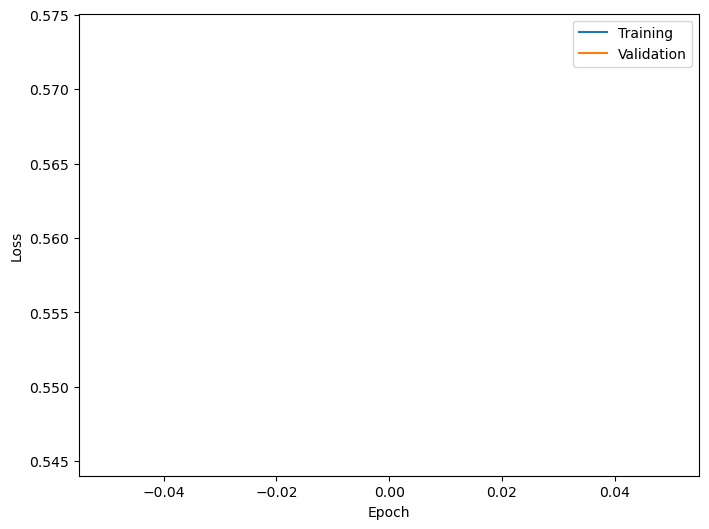

In [18]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), train_losses, label="Training")
ax.plot(np.arange(ep), val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# Multi-target

## DeiT III

In [19]:
deit3_multi = timm.create_model("deit3_base_patch16_224", pretrained = True)
num_classes = 2
deit3_multi.head = nn.Linear(deit3_multi.head.in_features, num_classes)

# Freeze all parameters first
for param in deit3_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(deit3_multi, "head"):
    for param in deit3_multi.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze transformer blocks
num_unfreeze = 6
if hasattr(deit3_multi, "blocks"):
    for block in deit3_multi.blocks[-num_unfreeze:]:
        for param in block.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deit3_multi = deit3_multi.to(device)

config = timm.data.resolve_model_data_config(deit3_multi)

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Lambda(lambda t: aggressive_arcsinh(t)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

multidata = DC.ClassificationDataset(datadir, labels, transform = transform)

In [20]:
len(deit3_multi.blocks)

12

In [21]:
strat_labels = np.empty((len(labels.data), 2), dtype = int)
mask_pre = labels.data['is_pre_merger'] == 1
mask_post = labels.data['is_post_merger'] == 1
mask_ongoing = labels.data['is_ongoing_merger'] == 1
mask_non = labels.data['is_major_merger'] == 0

strat_labels[mask_pre, :] = [1,0]
strat_labels[mask_post | mask_ongoing, :] = [0,1]
strat_labels[mask_non, :] = [0,0]
strat_labels[mask_pre & mask_post] = [1,1]

print(len(strat_labels[mask_pre]))
print(len(strat_labels[mask_post | mask_ongoing]))
print(len(strat_labels[mask_pre & mask_post]))
print(len(strat_labels[mask_non]))
print('')
print(np.sum((strat_labels == [1,0]).all(axis=1)))
print(np.sum((strat_labels == [0,1]).all(axis=1)))
print(np.sum((strat_labels == [1,1]).all(axis=1)))
print(np.sum((strat_labels == [0,0]).all(axis=1)))

1267
1147
31
56053

1236
1116
31
56053


In [22]:
all_indices = np.arange(len(multidata))

# First split: 80% train, 20% temporary (which will later be split into val and test)
train_idx, temp_idx = train_test_split(
    all_indices, test_size=0.20, stratify=strat_labels, random_state=42
)

train_strat_labels = strat_labels[train_idx]
desample_factor = 0.8
n00 = desample_factor*np.sum((train_strat_labels == [0,0]).all(axis=1))  # count for (0,0)
augmentation_factor = 2  #times x as augmenting with x times minority classes
n10 = augmentation_factor*np.sum((train_strat_labels == [1,0]).all(axis=1))  # count for (1,0)
n01 = augmentation_factor*np.sum((train_strat_labels == [0,1]).all(axis=1))  # count for (0,1)
n11 = augmentation_factor*np.sum((train_strat_labels == [1,1]).all(axis=1))  # count for (1,1)

pos_weight_first = (n00 + n01) / (n10 + n11)
pos_weight_second = (n00 + n10) / (n01 + n11)

pos_weight = torch.tensor([pos_weight_first, pos_weight_second], dtype=torch.float32)

# For the temp set, stratify again. Extract stratification labels for the temp indices.
temp_strat_labels = strat_labels[temp_idx]

# Second split: split temp indices equally into validation and test sets
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_strat_labels, random_state=42
)

# Create the Subset datasets
multi_train_dataset = Subset(multidata, train_idx)
multi_val_dataset = Subset(multidata, val_idx)
multi_test_dataset = Subset(multidata, test_idx)

In [ ]:
#all_indices = np.arange(len(multi_train_dataset))

# Create a boolean mask for the majority class (0,0)
mask_majority = np.all(train_strat_labels == [0,0], axis=1)
majority_indices = all_indices[mask_majority]

# Downsample the (0,0) samples to 80% of their original count
new_majority_indices = np.random.choice(majority_indices, 
                                          size=int(0.8 * len(majority_indices)), 
                                          replace=False)

# For the minority classes, keep all indices
minority_indices = all_indices[~mask_majority]

# Combine the indices and optionally shuffle them
new_indices = np.concatenate([new_majority_indices, minority_indices])
np.random.shuffle(new_indices)

train_strat_labels = train_strat_labels[new_indices]

# Create a new Subset dataset with the new indices
multi_train_dataset = Subset(multi_train_dataset, new_indices)

In [ ]:
# Create a boolean mask for minority samples (i.e., not [0,0])
minority_mask = ~np.all(train_strat_labels == [0,0], axis=1)
minority_indices = np.where(minority_mask)[0].tolist()

# Create a subset for the minority samples
minority_dataset = Subset(multi_train_dataset, minority_indices)

# Concatenate the original dataset with the minority subset (doubling the minority samples)
multi_train_dataset = ConcatDataset([multi_train_dataset, minority_dataset])

In [23]:
# train_size = int(0.81 * len(multidata))
# val_size = int(0.09*len(multidata))
# test_size = len(multidata) - train_size - val_size
# multi_train_dataset, multi_val_dataset, multi_test_dataset = random_split(multidata, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
persistent_workers = True
multi_train_loader = DataLoader(multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
multi_val_loader = DataLoader(multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
multi_test_loader = DataLoader(multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

x,y = next(iter(multi_train_loader))
print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
print("y batch shape:", y.shape)  # Should be [batch_size, 3]

x batch shape: torch.Size([256, 3, 224, 224])
y batch shape: torch.Size([256, 2])


In [24]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#optimizer = optim.Adam(deit3_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(deit3_multi.parameters(),
                        lr=1e-3,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [25]:
epochs = 1
deit3_multi_train_losses = []
deit3_multi_val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(deit3_multi, multi_train_loader, optimizer, criterion, device, unsqueezeY = False)
    val_loss = AF.evaluation_epoch(deit3_multi, multi_val_loader, criterion, device, desc = 'validation', unsqueezeY = False)

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    deit3_multi_train_losses.append(train_loss)
    deit3_multi_val_losses.append(val_loss)


deit3_multi_epoch_loss, deit3_multi_epoch_acc, deit3_multi_all_preds, deit3_multi_all_labels = AF.multilabel_evaluate(deit3_multi, multi_test_loader,
                                                                                                                  criterion, device)

Epoch 1/1 - Learning Rate: 0.001000


Training:   0%|                                                                                 | 0/183 [00:00<?, ?it/s]/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.104691 | Val Loss: 0.099201


Text(0, 0.5, 'Loss')

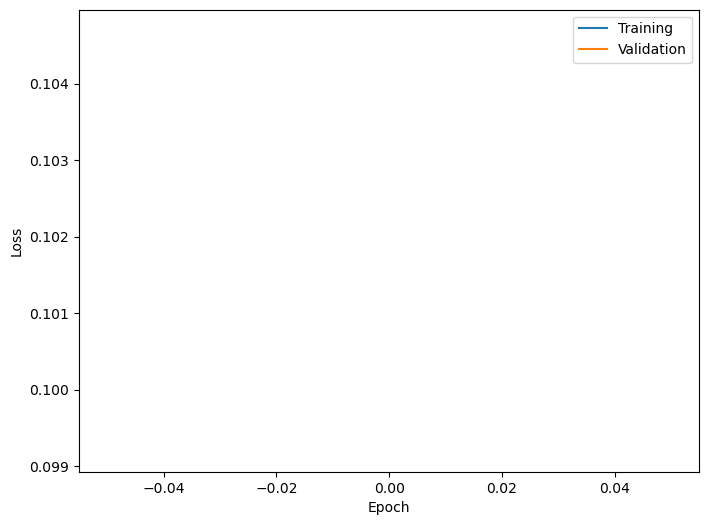

In [26]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), deit3_multi_train_losses, label="Training")
ax.plot(np.arange(ep), deit3_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

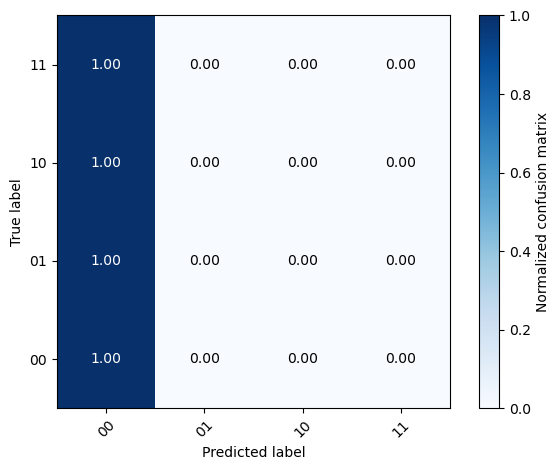

In [27]:
af.multilabel_plot_confusion_matrix(deit3_multi_all_labels, deit3_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

## Swin V2

In [28]:
swin_multi = timm.create_model("swinv2_base_window16_256", pretrained = True)
num_classes = 2
#swin_multi.head = nn.Linear(swin_multi.head.in_features, num_classes)
swin_multi.reset_classifier(num_classes, global_pool='avg')

# Freeze all parameters first
for param in swin_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(swin_multi, "head"):
    for param in swin_multi.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze layers
num_unfreeze = 1
for layers in swin_multi.layers[-num_unfreeze:]:
        for param in layers.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi = swin_multi.to(device)

config = timm.data.resolve_model_data_config(swin_multi)

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Lambda(lambda t: aggressive_arcsinh(t)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

swin_multidata = DC.ClassificationDataset(datadir, labels, transform = transform)

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [29]:
len(swin_multi.layers)

4

In [30]:
# all_indices = np.arange(len(multidata))

# # First split: 80% train, 20% temporary (which will later be split into val and test)
# train_idx, temp_idx = train_test_split(
#     all_indices, test_size=0.20, stratify=strat_labels, random_state=42
# )

# # For the temp set, stratify again. Extract stratification labels for the temp indices.
# temp_strat_labels = strat_labels[temp_idx]

# # Second split: split temp indices equally into validation and test sets
# val_idx, test_idx = train_test_split(
#     temp_idx, test_size=0.5, stratify=temp_strat_labels, random_state=42
# )

# Create the Subset datasets
swin_multi_train_dataset = Subset(swin_multidata, train_idx)
swin_multi_val_dataset = Subset(swin_multidata, val_idx)
swin_multi_test_dataset = Subset(swin_multidata, test_idx)

In [ ]:
#all_indices = np.arange(len(multi_train_dataset))

# Create a boolean mask for the majority class (0,0)
mask_majority = np.all(train_strat_labels == [0,0], axis=1)
majority_indices = all_indices[mask_majority]

# Downsample the (0,0) samples to 80% of their original count
new_majority_indices = np.random.choice(majority_indices, 
                                          size=int(0.8 * len(majority_indices)), 
                                          replace=False)

# For the minority classes, keep all indices
minority_indices = all_indices[~mask_majority]

# Combine the indices and optionally shuffle them
new_indices = np.concatenate([new_majority_indices, minority_indices])
np.random.shuffle(new_indices)

train_strat_labels = train_strat_labels[new_indices]

# Create a new Subset dataset with the new indices
multi_train_dataset = Subset(multi_train_dataset, new_indices)

In [ ]:
# Create a boolean mask for minority samples (i.e., not [0,0])
minority_mask = ~np.all(train_strat_labels == [0,0], axis=1)
minority_indices = np.where(minority_mask)[0].tolist()

# Create a subset for the minority samples
minority_dataset = Subset(swin_multi_train_dataset, minority_indices)

# Concatenate the original dataset with the minority subset (doubling the minority samples)
swin_multi_train_dataset = ConcatDataset([swin_multi_train_dataset, minority_dataset])

In [31]:
# train_size = int(0.81 * len(swin_multidata))
# val_size = int(0.09*len(swin_multidata))
# test_size = len(swin_multidata) - train_size - val_size
# swin_multi_train_dataset, swin_multi_val_dataset, swin_multi_test_dataset = random_split(swin_multidata, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
persistent_workers = True
swin_multi_train_loader = DataLoader(swin_multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_val_loader = DataLoader(swin_multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_test_loader = DataLoader(swin_multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

x,y = next(iter(swin_multi_train_loader))
print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
print("y batch shape:", y.shape)  # Should be [batch_size, 3]

x batch shape: torch.Size([256, 3, 256, 256])
y batch shape: torch.Size([256, 2])


In [32]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#optimizer = optim.Adam(swin_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(swin_multi.parameters(),
                        lr=1e-3,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [33]:
epochs = 1
swin_multi_train_losses = []
swin_multi_val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(swin_multi, swin_multi_train_loader, optimizer, criterion, device, unsqueezeY = False)
    val_loss = AF.evaluation_epoch(swin_multi, swin_multi_val_loader, criterion, device, desc = 'validation', unsqueezeY = False)

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    swin_multi_train_losses.append(train_loss)
    swin_multi_val_losses.append(val_loss)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels = AF.multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

Epoch 1/1 - Learning Rate: 0.001000


Training:   0%|                                                                                 | 0/183 [00:00<?, ?it/s]/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.103042 | Val Loss: 0.098344


Text(0, 0.5, 'Loss')

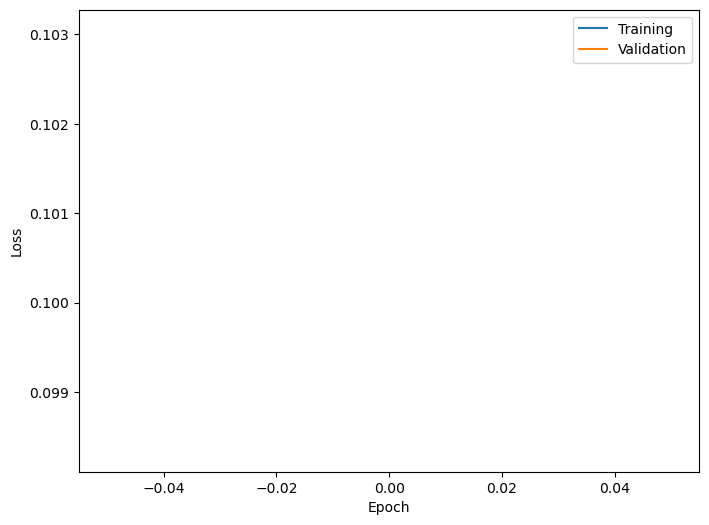

In [35]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), swin_multi_train_losses, label="Training")
ax.plot(np.arange(ep), swin_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

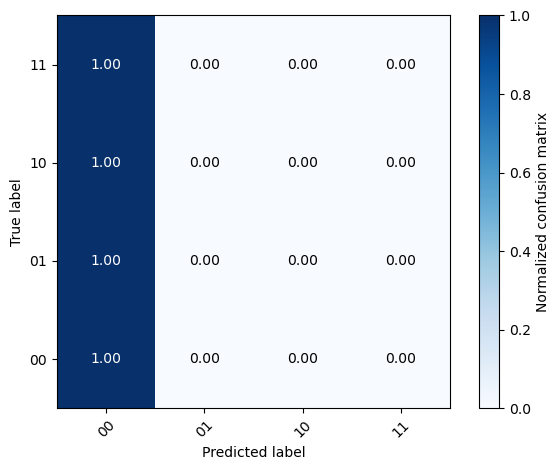

In [36]:
af.multilabel_plot_confusion_matrix(deit3_multi_all_labels, deit3_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [1]:
# def get_strat_labels(dataset):
#     labels = []
#     for i in range(len(dataset)):
#         _, label = dataset[i]
#         label = tuple(label.cpu().numpy())
#         labels.append(label)
#     return labels

# def print_distribution_ratios(labels, subset_name=""):
#     counts = Counter(labels)
#     total = sum(counts.values())
#     print(f"{subset_name} distribution ratios:")
#     for label, count in counts.items():
#         ratio = count / total
#         print(f"  {label}: {ratio:.3f}")
#     print()

# orig_labels = get_strat_labels(multidata)
# train_labels = get_strat_labels(swin_multi_train_dataset)
# val_labels = get_strat_labels(swin_multi_val_dataset)
# test_labels = get_strat_labels(swin_multi_test_dataset)

# print_distribution_ratios(orig_labels, "Original")
# print_distribution_ratios(train_labels, "Train")
# print_distribution_ratios(val_labels, "Validation")
# print_distribution_ratios(test_labels, "Test")